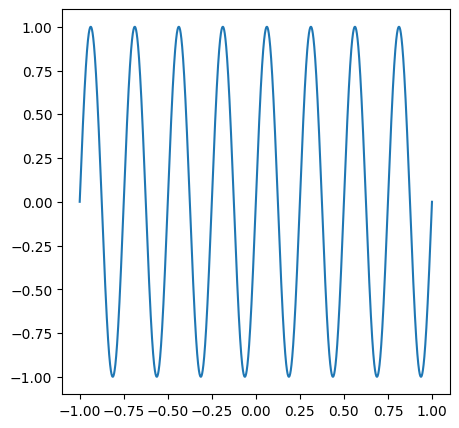

In [1]:
import numpy as np
from numba import jit
from numpy.random import default_rng as rg
rng = rg(12345)
from tqdm import tqdm
import sys
sys.path.append('../core')
%matplotlib inline
import torch
torch.manual_seed(0)
import torch.optim as optim
from FLDojo import dojo
from FL import FL
from DNN_R import DNN
from display2 import*
Xs = np.linspace(-1,1,40000)
Ys = np.sin(Xs*8*np.pi)
from matplotlib import pyplot as plt
fig,axs = plt.subplots(1,1,figsize=(5,5))
axs.plot(Xs,Ys)

dnn_sizes = [1,102,101,1] # so # of weights is 102*1 + 102*102 + 102*1 = 10608  
fl_sizes = [1,100,100] # so # of weights is  1*a + a*1 + a*a + a*1 = 10300, for a = 100
fl_adapt_sizes = lambda k : [1,k*32,k*32] # so # of weights is  1*a + a*1 + a*a + a*1 = 10300, for a = 100

fl_sizes2 = [1,25,25] # so # of weights is  1*a + a*1 + a*a + a*1 = 700, for a = 25
dnn_sizes2 = [1,26,26,1] # so # of weights is 26*1 + 26*26 + 26*1 = 728
# a three layer nn can represent any multivariate function (continuous or discontinuous) https://arxiv.org/abs/2012.03016

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
p = np.random.permutation(len(Xs))
Xs = Xs[p]
X = torch.from_numpy(Xs).float().unsqueeze(1).to(device)
split = 0.75
train_X = X[:int(split*len(X))]
test_X = X[int(split*len(X)):]

def update_y(k):
    Ys = np.sin(Xs*k)
    y = torch.from_numpy(Ys).float().unsqueeze(1).to(device)
    train_y = y[:int(split*len(y))]
    test_y = y[int(split*len(y)):]
    return train_y, test_y

In [3]:
D = dojo()
D.epochs=1000
D.max_batch_size=train_X.shape[0]
opt = lambda x: optim.Adam(x, lr=0.00001) # Adam better than SGD and AdamW in quick tests.
act = torch.nn.ReLU()
delta = np.array([1]*len(fl_sizes))*0.00005

100%|██████████| 1000/1000 [00:34<00:00, 29.19it/s]


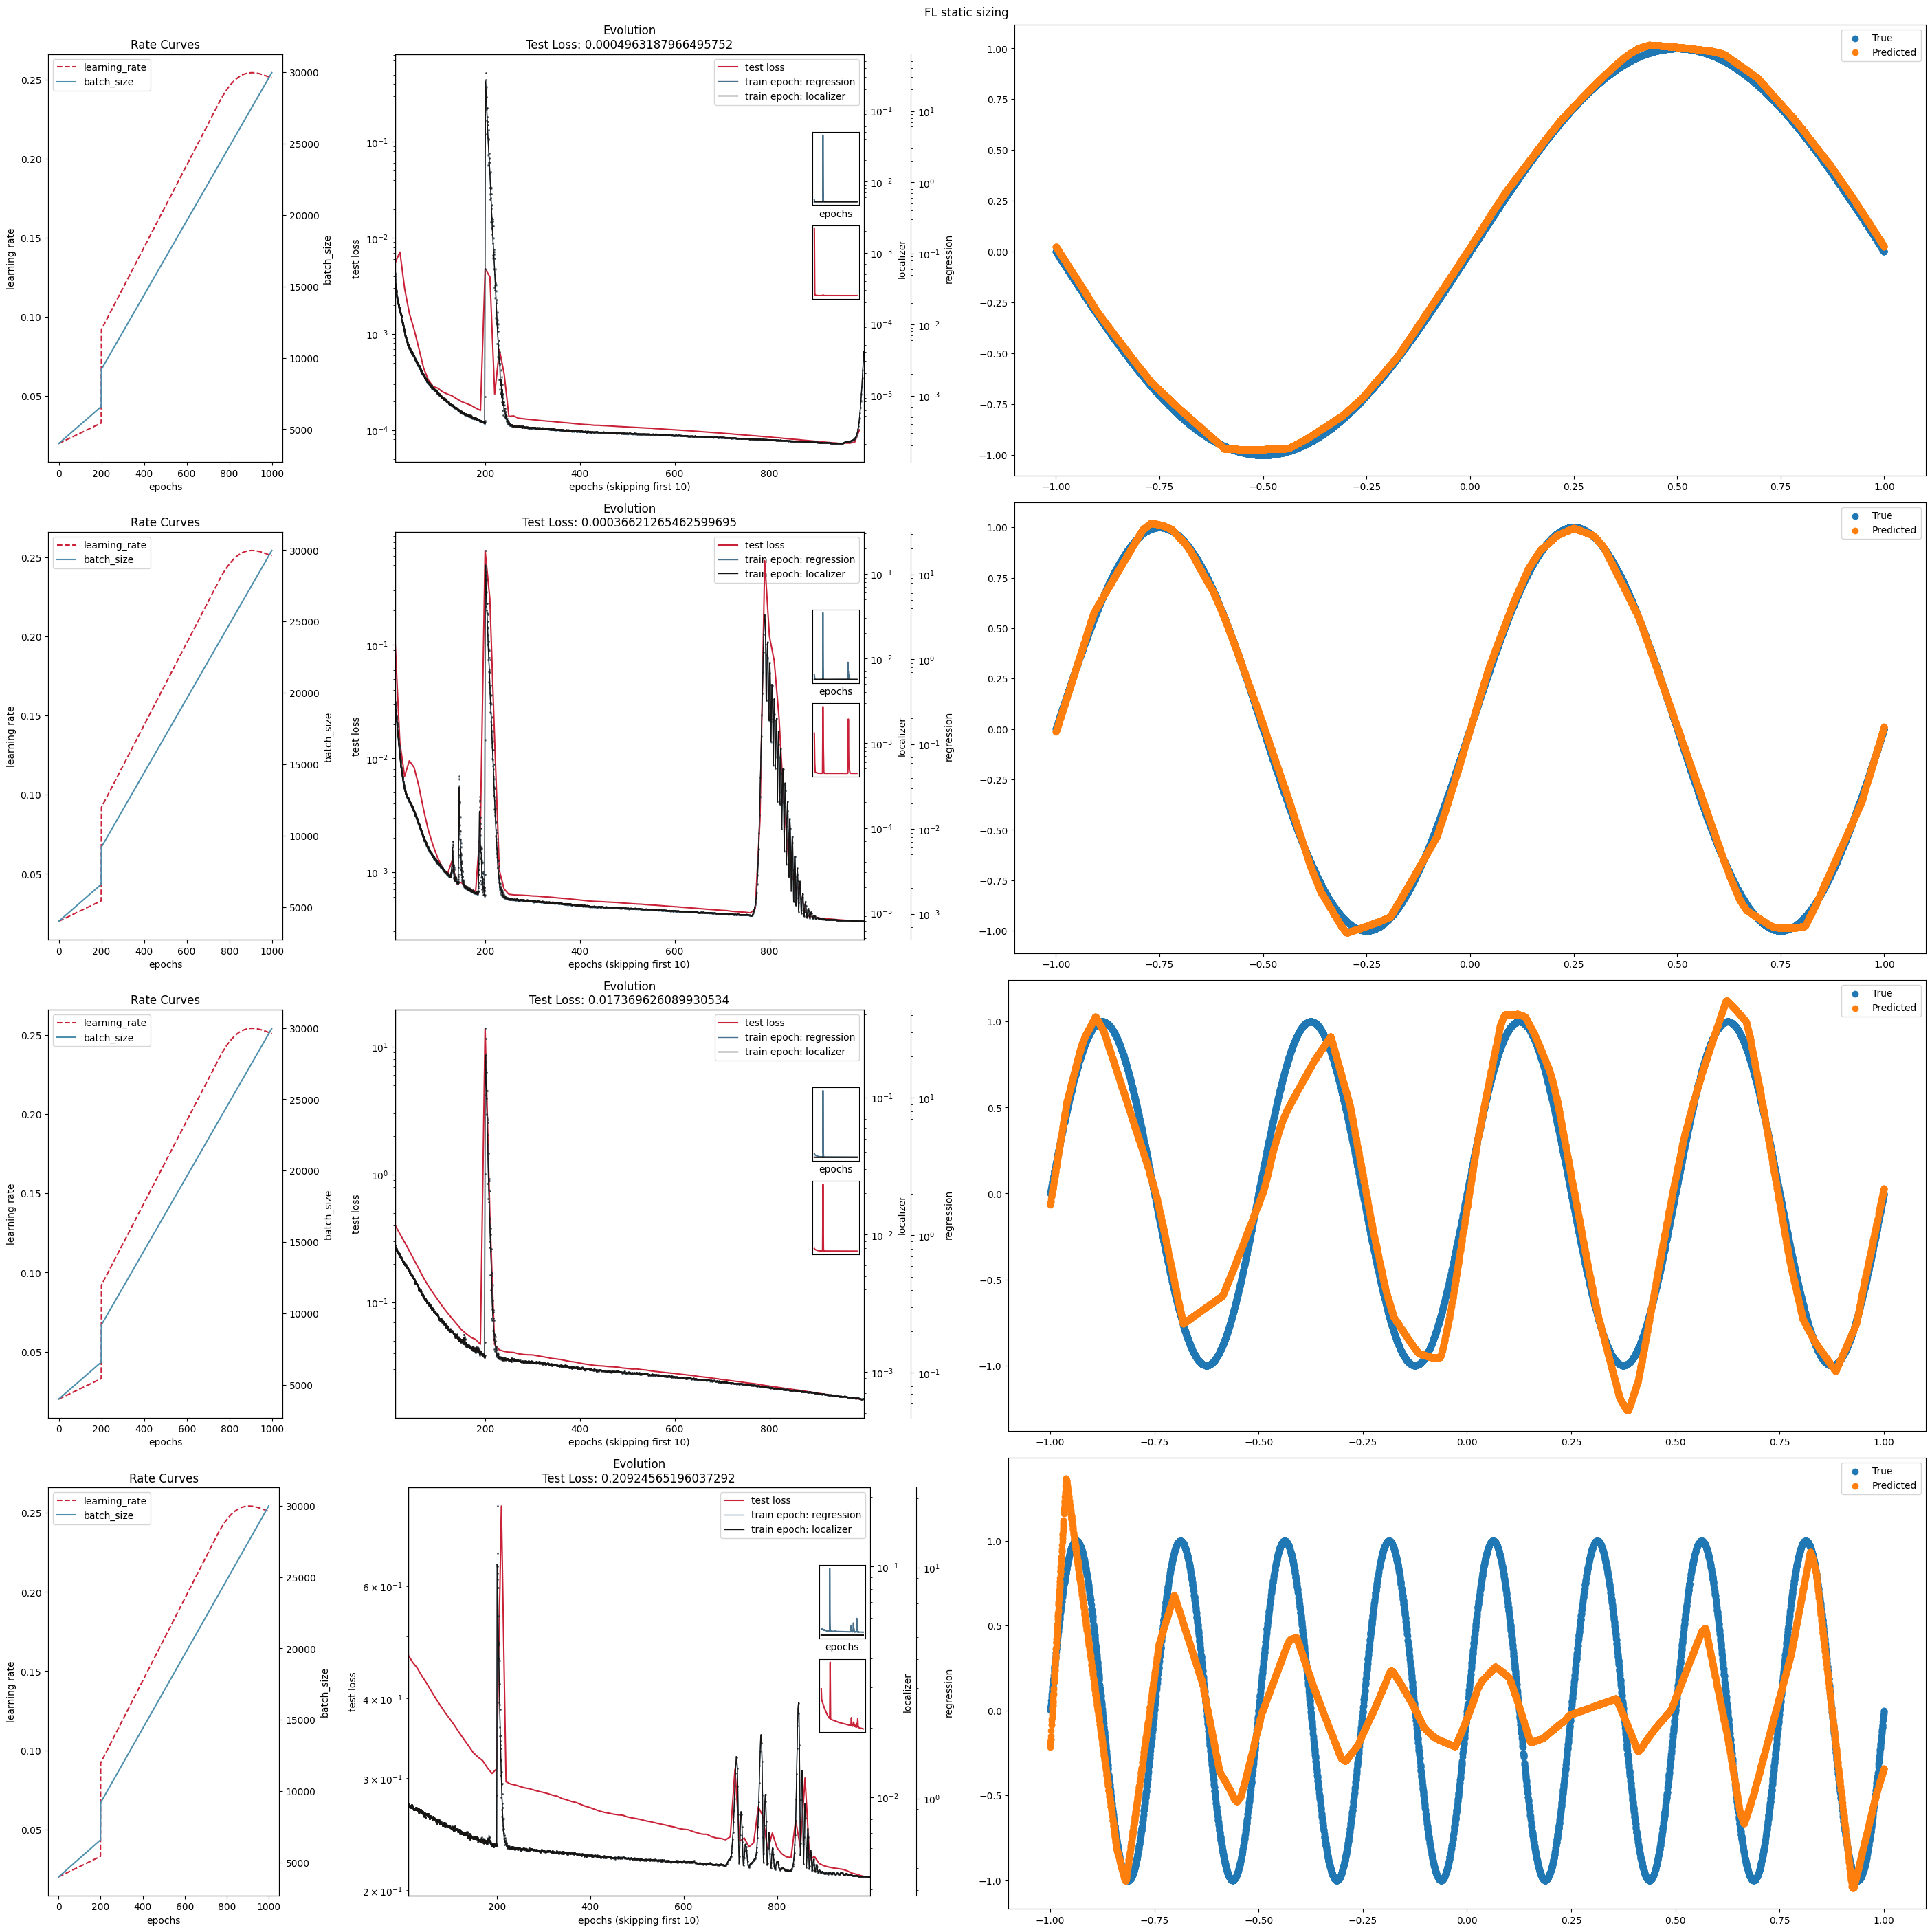

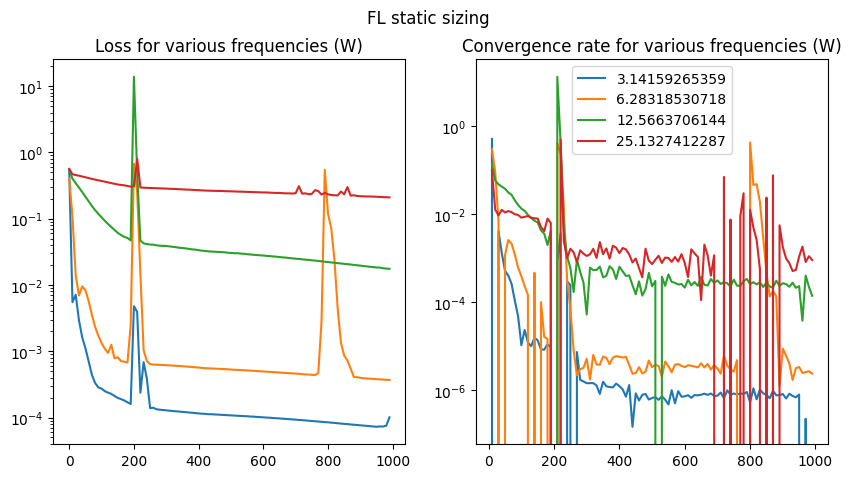

100%|██████████| 1000/1000 [05:02<00:00,  3.31it/s]


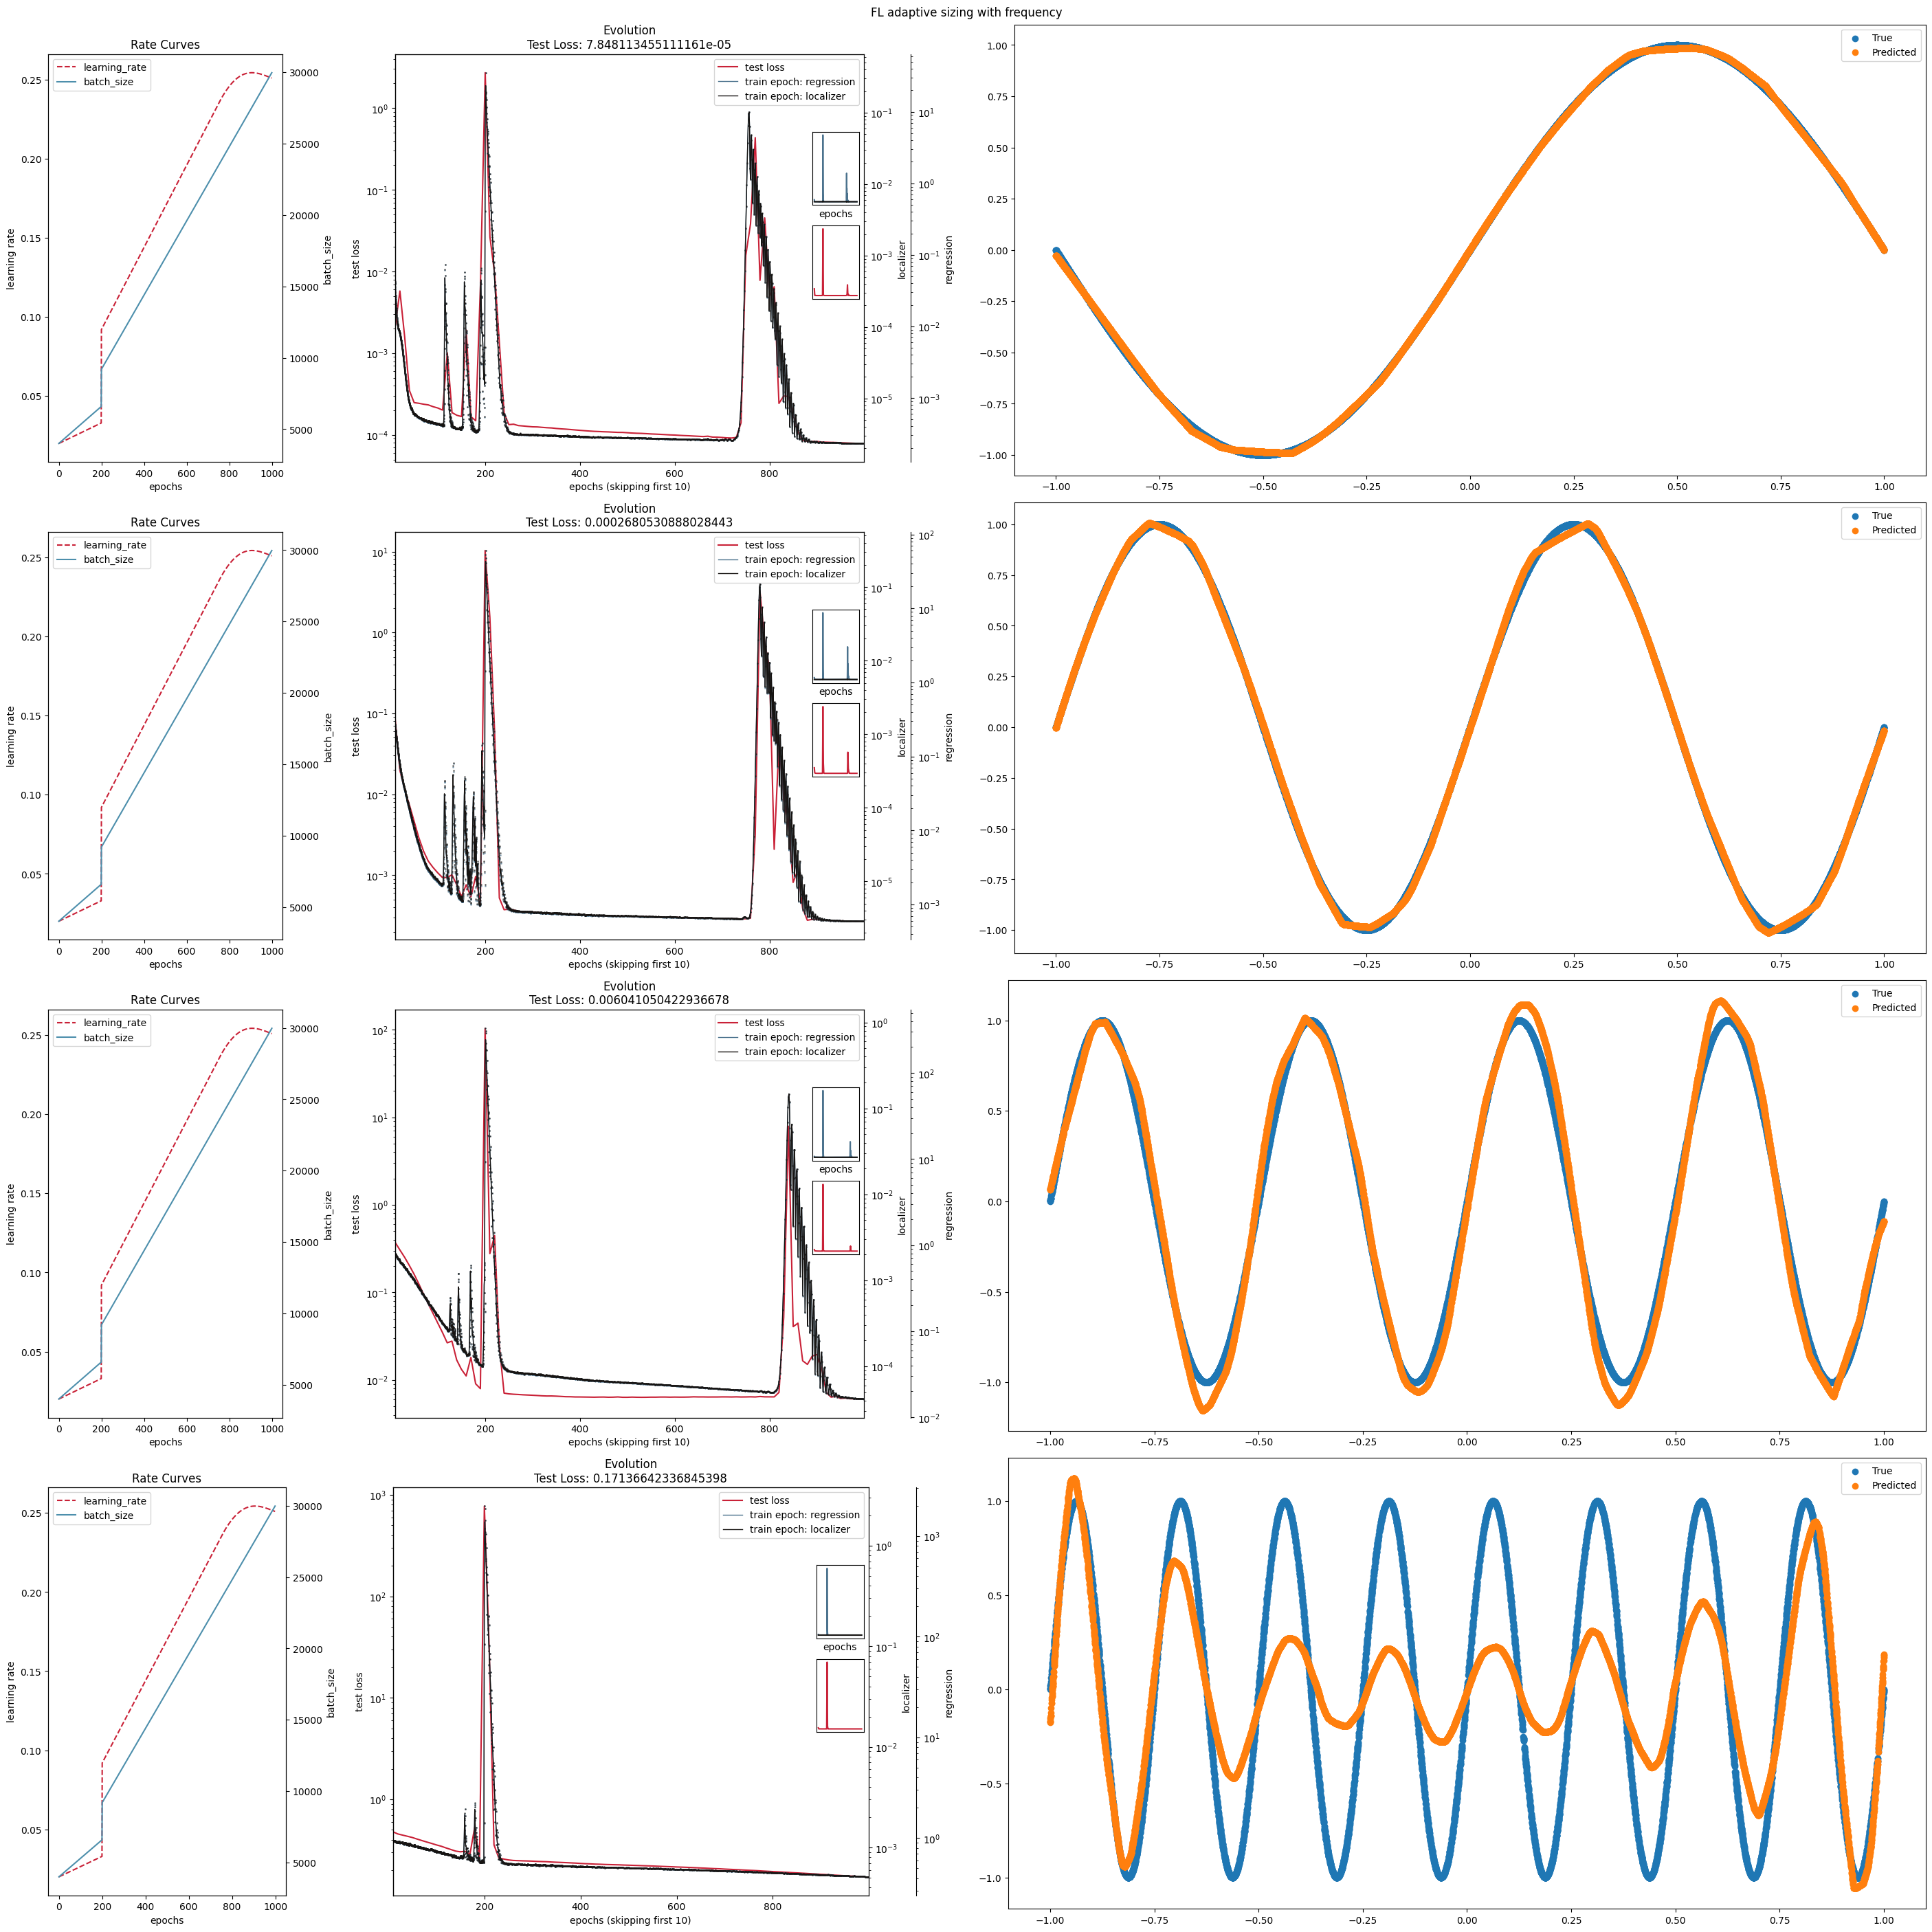

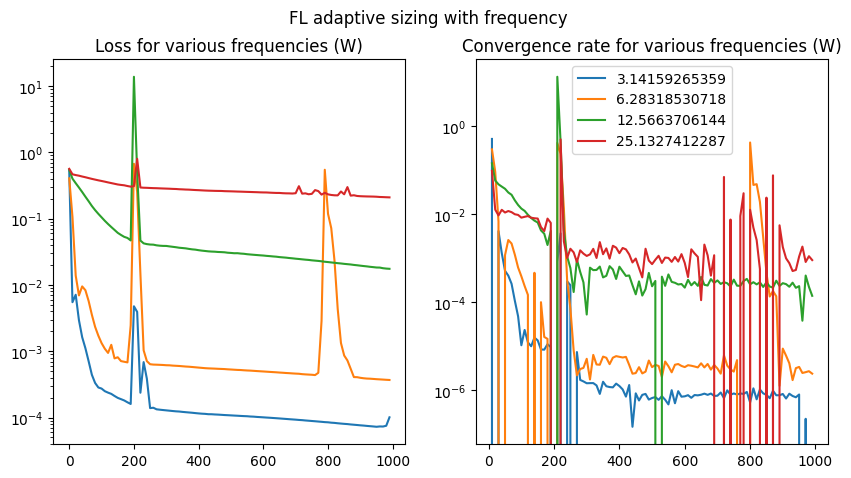

In [4]:
reports = []
ks_ = np.array([1,2,4,8])*np.pi
for j in range(2):
    st = 'FL static sizing' if j == 0 else 'FL adaptive sizing with frequency'
    fig = plt.figure(layout='constrained', figsize=(28,28))
    subfigs = fig.subfigures(len(ks_),1, hspace=0.01)
    for i,ks in enumerate(ks_):
        train_y,test_y = update_y(ks)


        k = [ks]*len(fl_sizes)
        if j == 0:
            net = FL(device, fl_sizes, delta, k, opttype=opt, act = act, bias=True)
        else:
            net = FL(device, fl_adapt_sizes(int(ks)), delta, k, opttype=opt, act = act, bias=True)
        report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=4000)
        sfgs = subfigs[i].subfigures(1,2)
        ecran(net, test_X, test_y, report, classification=False,subfig = sfgs[0])
        p1 = sfgs[1].subplots(1,1)
        p1.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
        p1.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
        p1.legend()
        reports.append(report)
    fig.suptitle(st)
    plt.show()
    plt.close(fig)
    fig,axs = plt.subplots(1,2,figsize=(10,5))
    axs[0].set_title('Loss for various frequencies (W)')
    axs[1].set_title('Convergence rate for various frequencies (W)')
    for i in range(len(ks_)):
        axs[0].plot(reports[i][-2],reports[i][-1],label=ks_[i])
        axs[1].plot(reports[i][-2][1:],-np.diff(reports[i][-1]),label=ks_[i])
        axs[0].set_yscale('log')
        axs[1].set_yscale('log')
    fig.suptitle(st)
    plt.legend()
    plt.show()
    plt.close(fig)

In [7]:
D.epochs=1000
D.max_batch_size=train_X.shape[0]
opt = lambda x: optim.Adam(x, lr=0.00001) # Adam better than SGD and AdamW in quick tests.

100%|██████████| 1000/1000 [00:15<00:00, 63.82it/s]


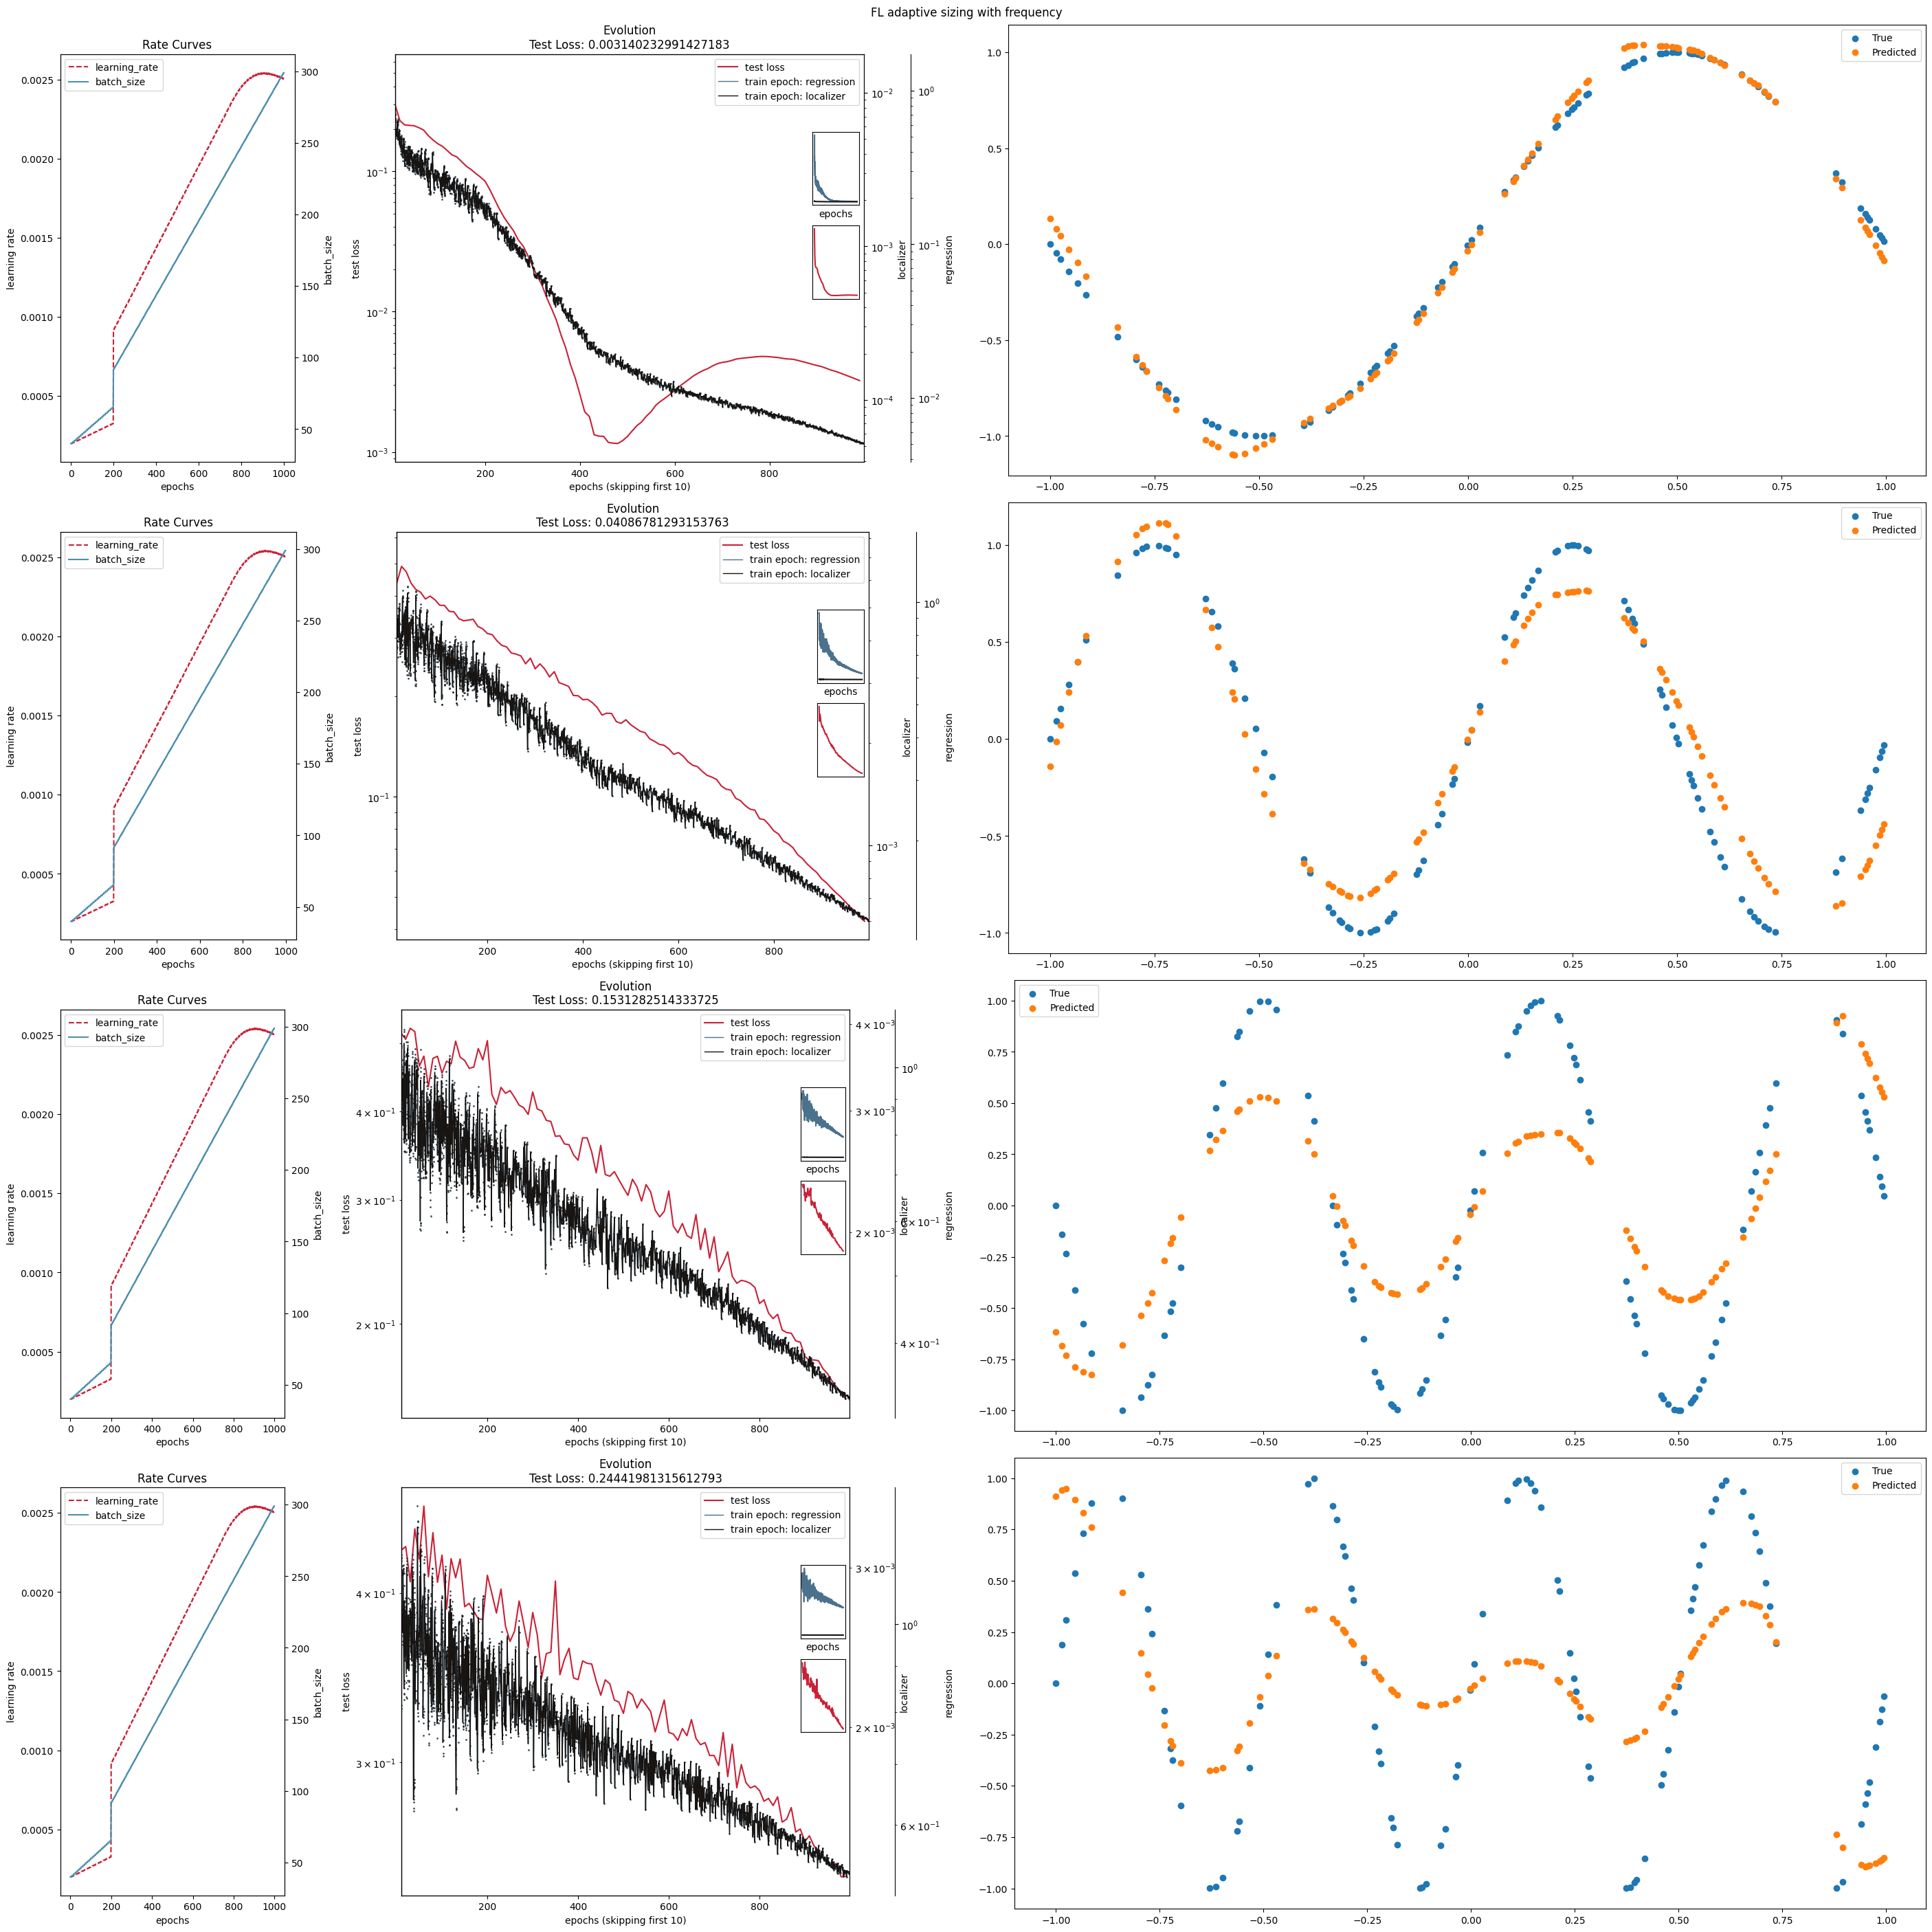

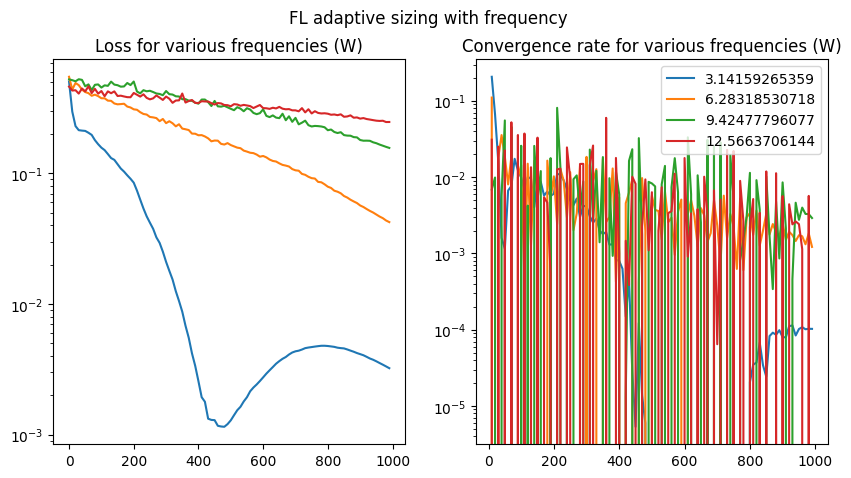

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Xs = np.linspace(-1,1,400)
p = np.random.permutation(len(Xs))
Xs = Xs[p]
X = torch.from_numpy(Xs).float().unsqueeze(1).to(device)
split = 0.75
train_X = X[:int(split*len(X))]
test_X = X[int(split*len(X)):]
def update_y2(k):
    Ys = np.sin(Xs*k)
    y = torch.from_numpy(Ys).float().unsqueeze(1).to(device)
    train_y = y[:int(split*len(y))]
    test_y = y[int(split*len(y)):]
    return train_y, test_y

reports = []
ks_ = np.array([1,2,3,4])*np.pi

for j in range(1,2):
    st = 'FL static sizing' if j == 0 else 'FL adaptive sizing with frequency'
    fig = plt.figure(layout='constrained', figsize=(28,28))
    subfigs = fig.subfigures(len(ks_),1, hspace=0.01)
    for i,ks in enumerate(ks_):
        train_y,test_y = update_y2(ks)


        k = [ks]*len(fl_sizes)
        if j == 0:
            net = FL(device, fl_sizes, delta, k, opttype=opt, act = act, bias=True)
        else:
            net = FL(device, fl_adapt_sizes(int(ks)), delta, k, opttype=opt, act = act, bias=True)
        report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=40)
        sfgs = subfigs[i].subfigures(1,2)
        ecran(net, test_X, test_y, report, classification=False,subfig = sfgs[0])
        p1 = sfgs[1].subplots(1,1)
        p1.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
        p1.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
        p1.legend()
        reports.append(report)
    fig.suptitle(st)
    plt.show()
    plt.close(fig)
    fig,axs = plt.subplots(1,2,figsize=(10,5))
    axs[0].set_title('Loss for various frequencies (W)')
    axs[1].set_title('Convergence rate for various frequencies (W)')
    for i in range(len(ks_)):
        axs[0].plot(reports[i][-2],reports[i][-1],label=ks_[i])
        axs[1].plot(reports[i][-2][1:],-np.diff(reports[i][-1]),label=ks_[i])
        axs[0].set_yscale('log')
        axs[1].set_yscale('log')
    fig.suptitle(st)
    plt.legend()
    plt.show()
    plt.close(fig)

100%|██████████| 1000/1000 [00:10<00:00, 93.51it/s] 


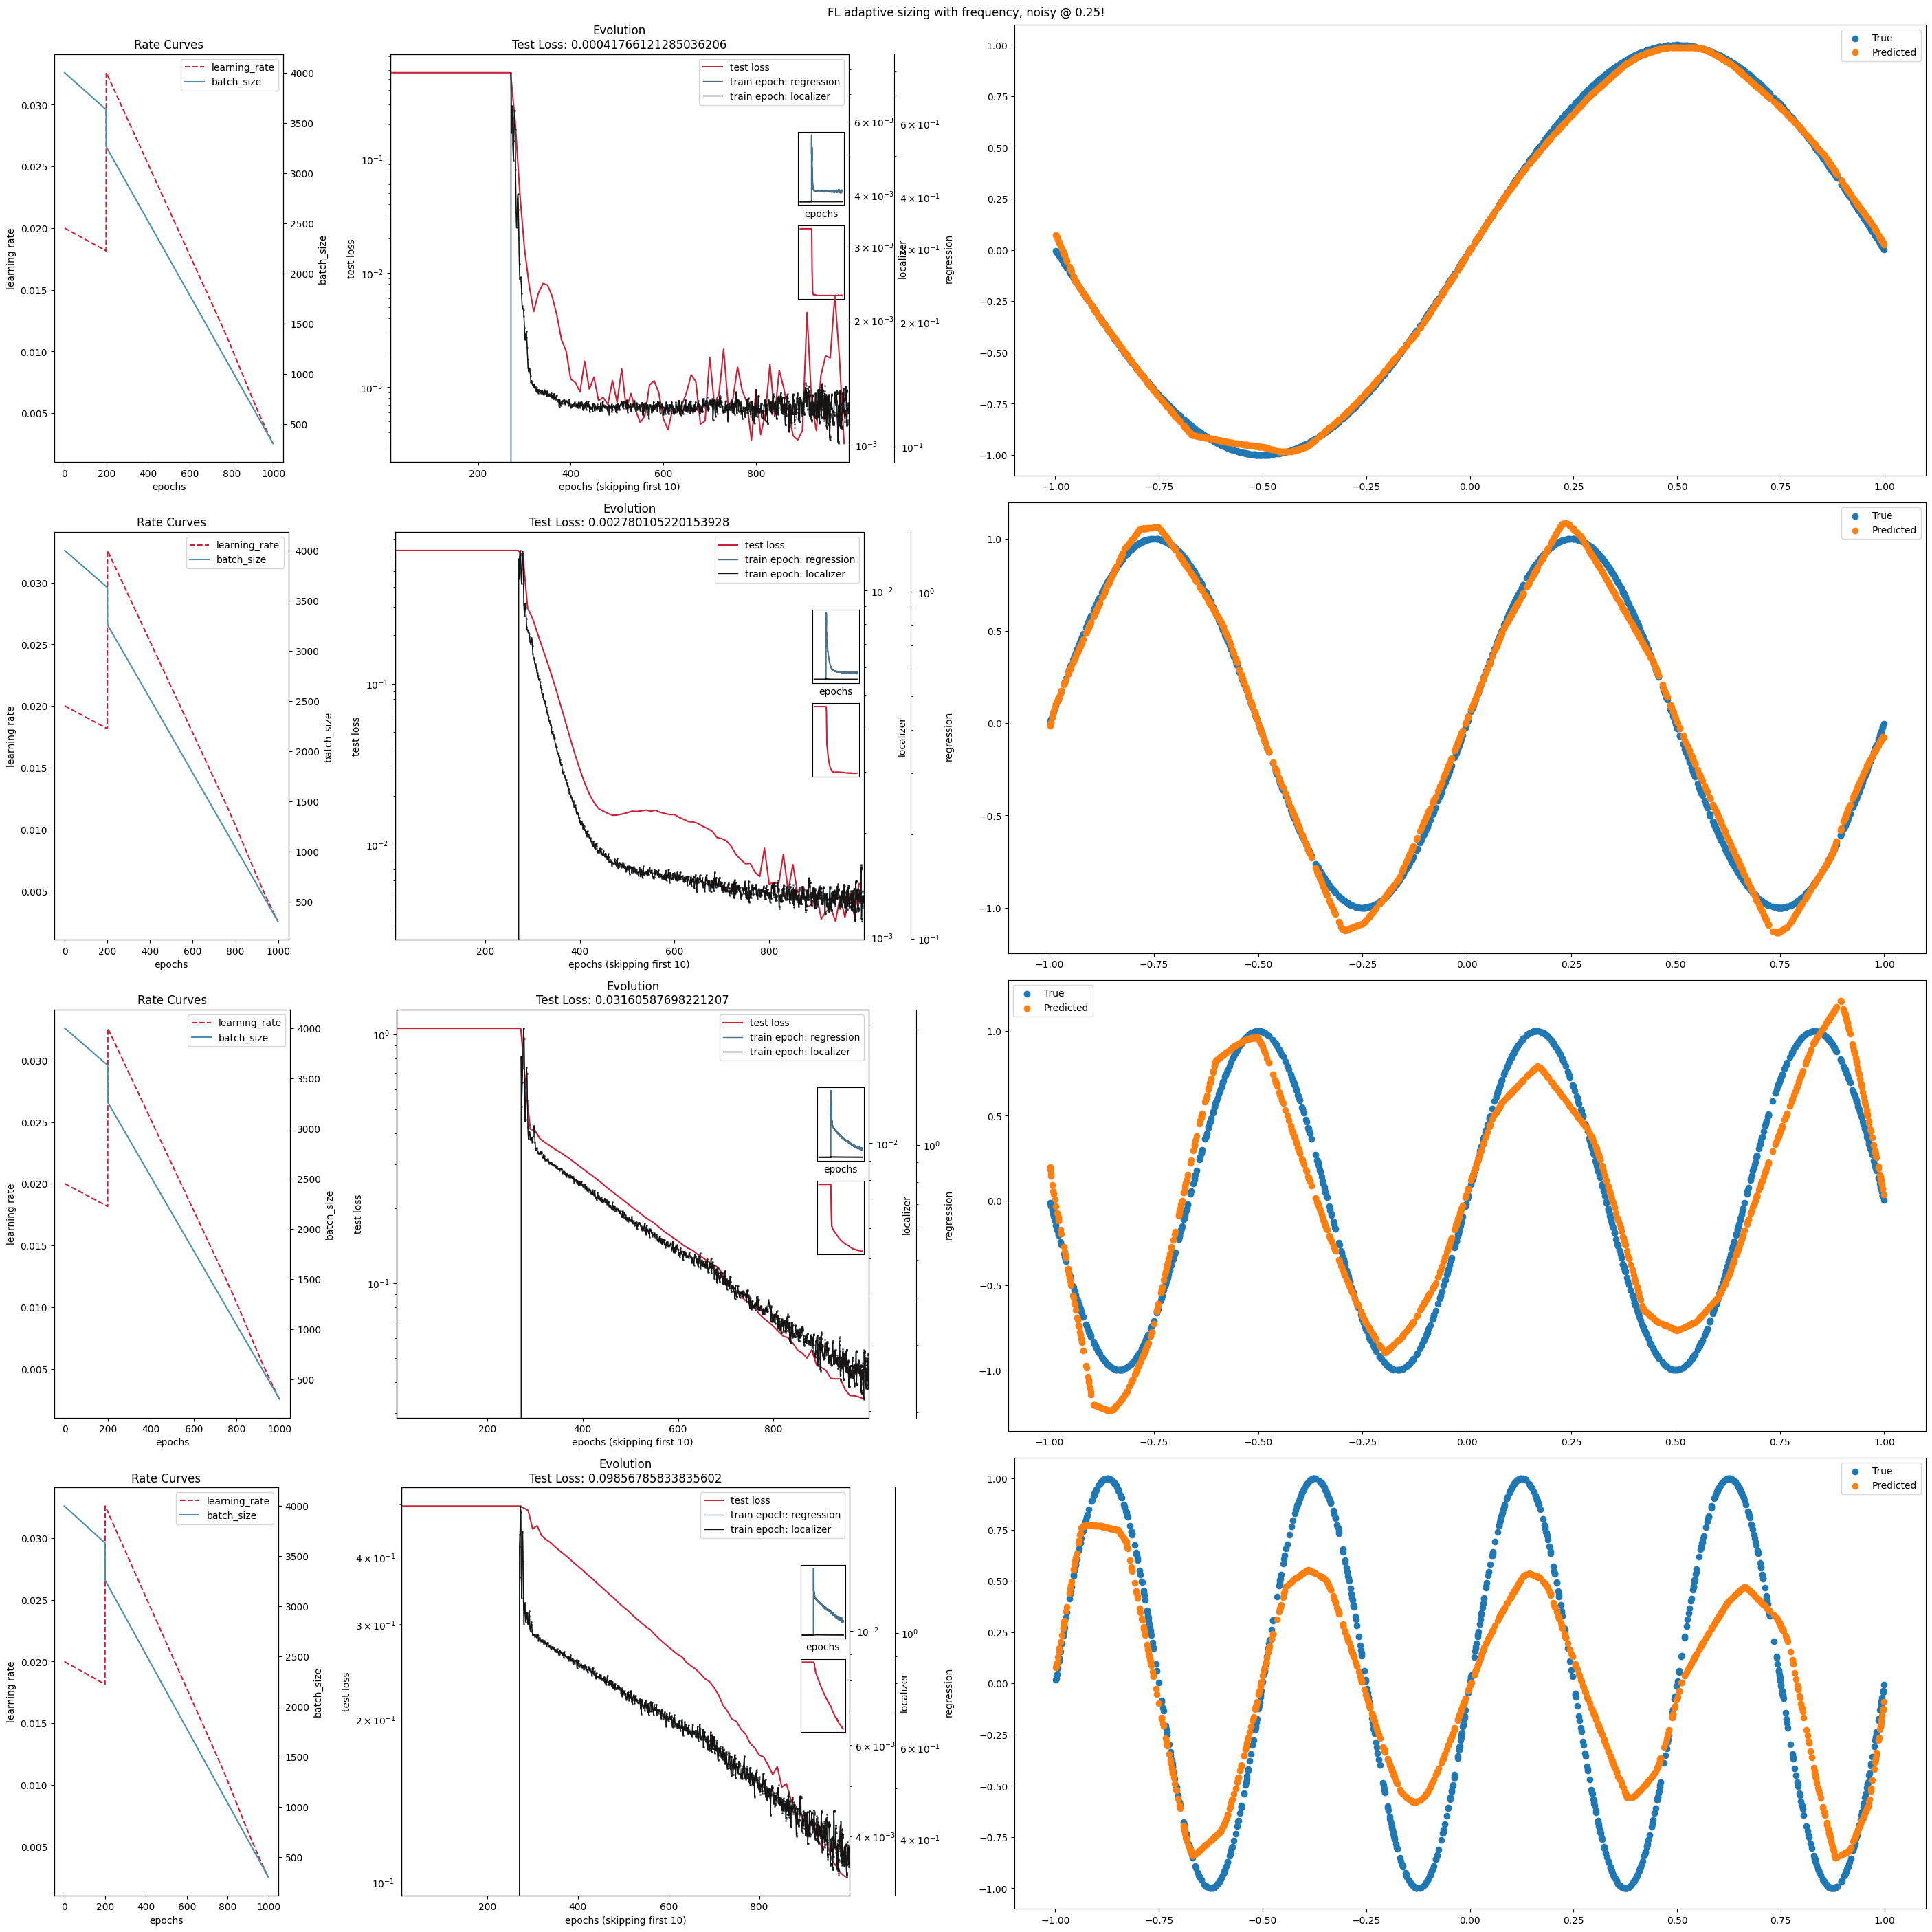

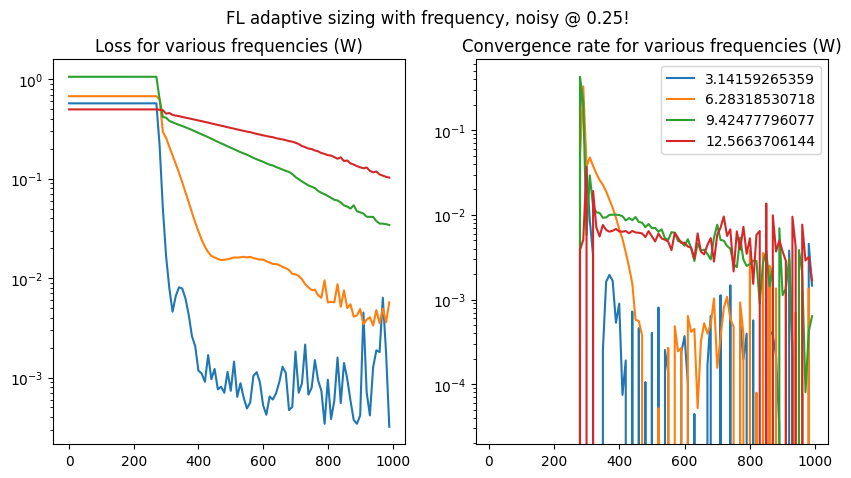

100%|██████████| 1000/1000 [00:14<00:00, 69.54it/s] 


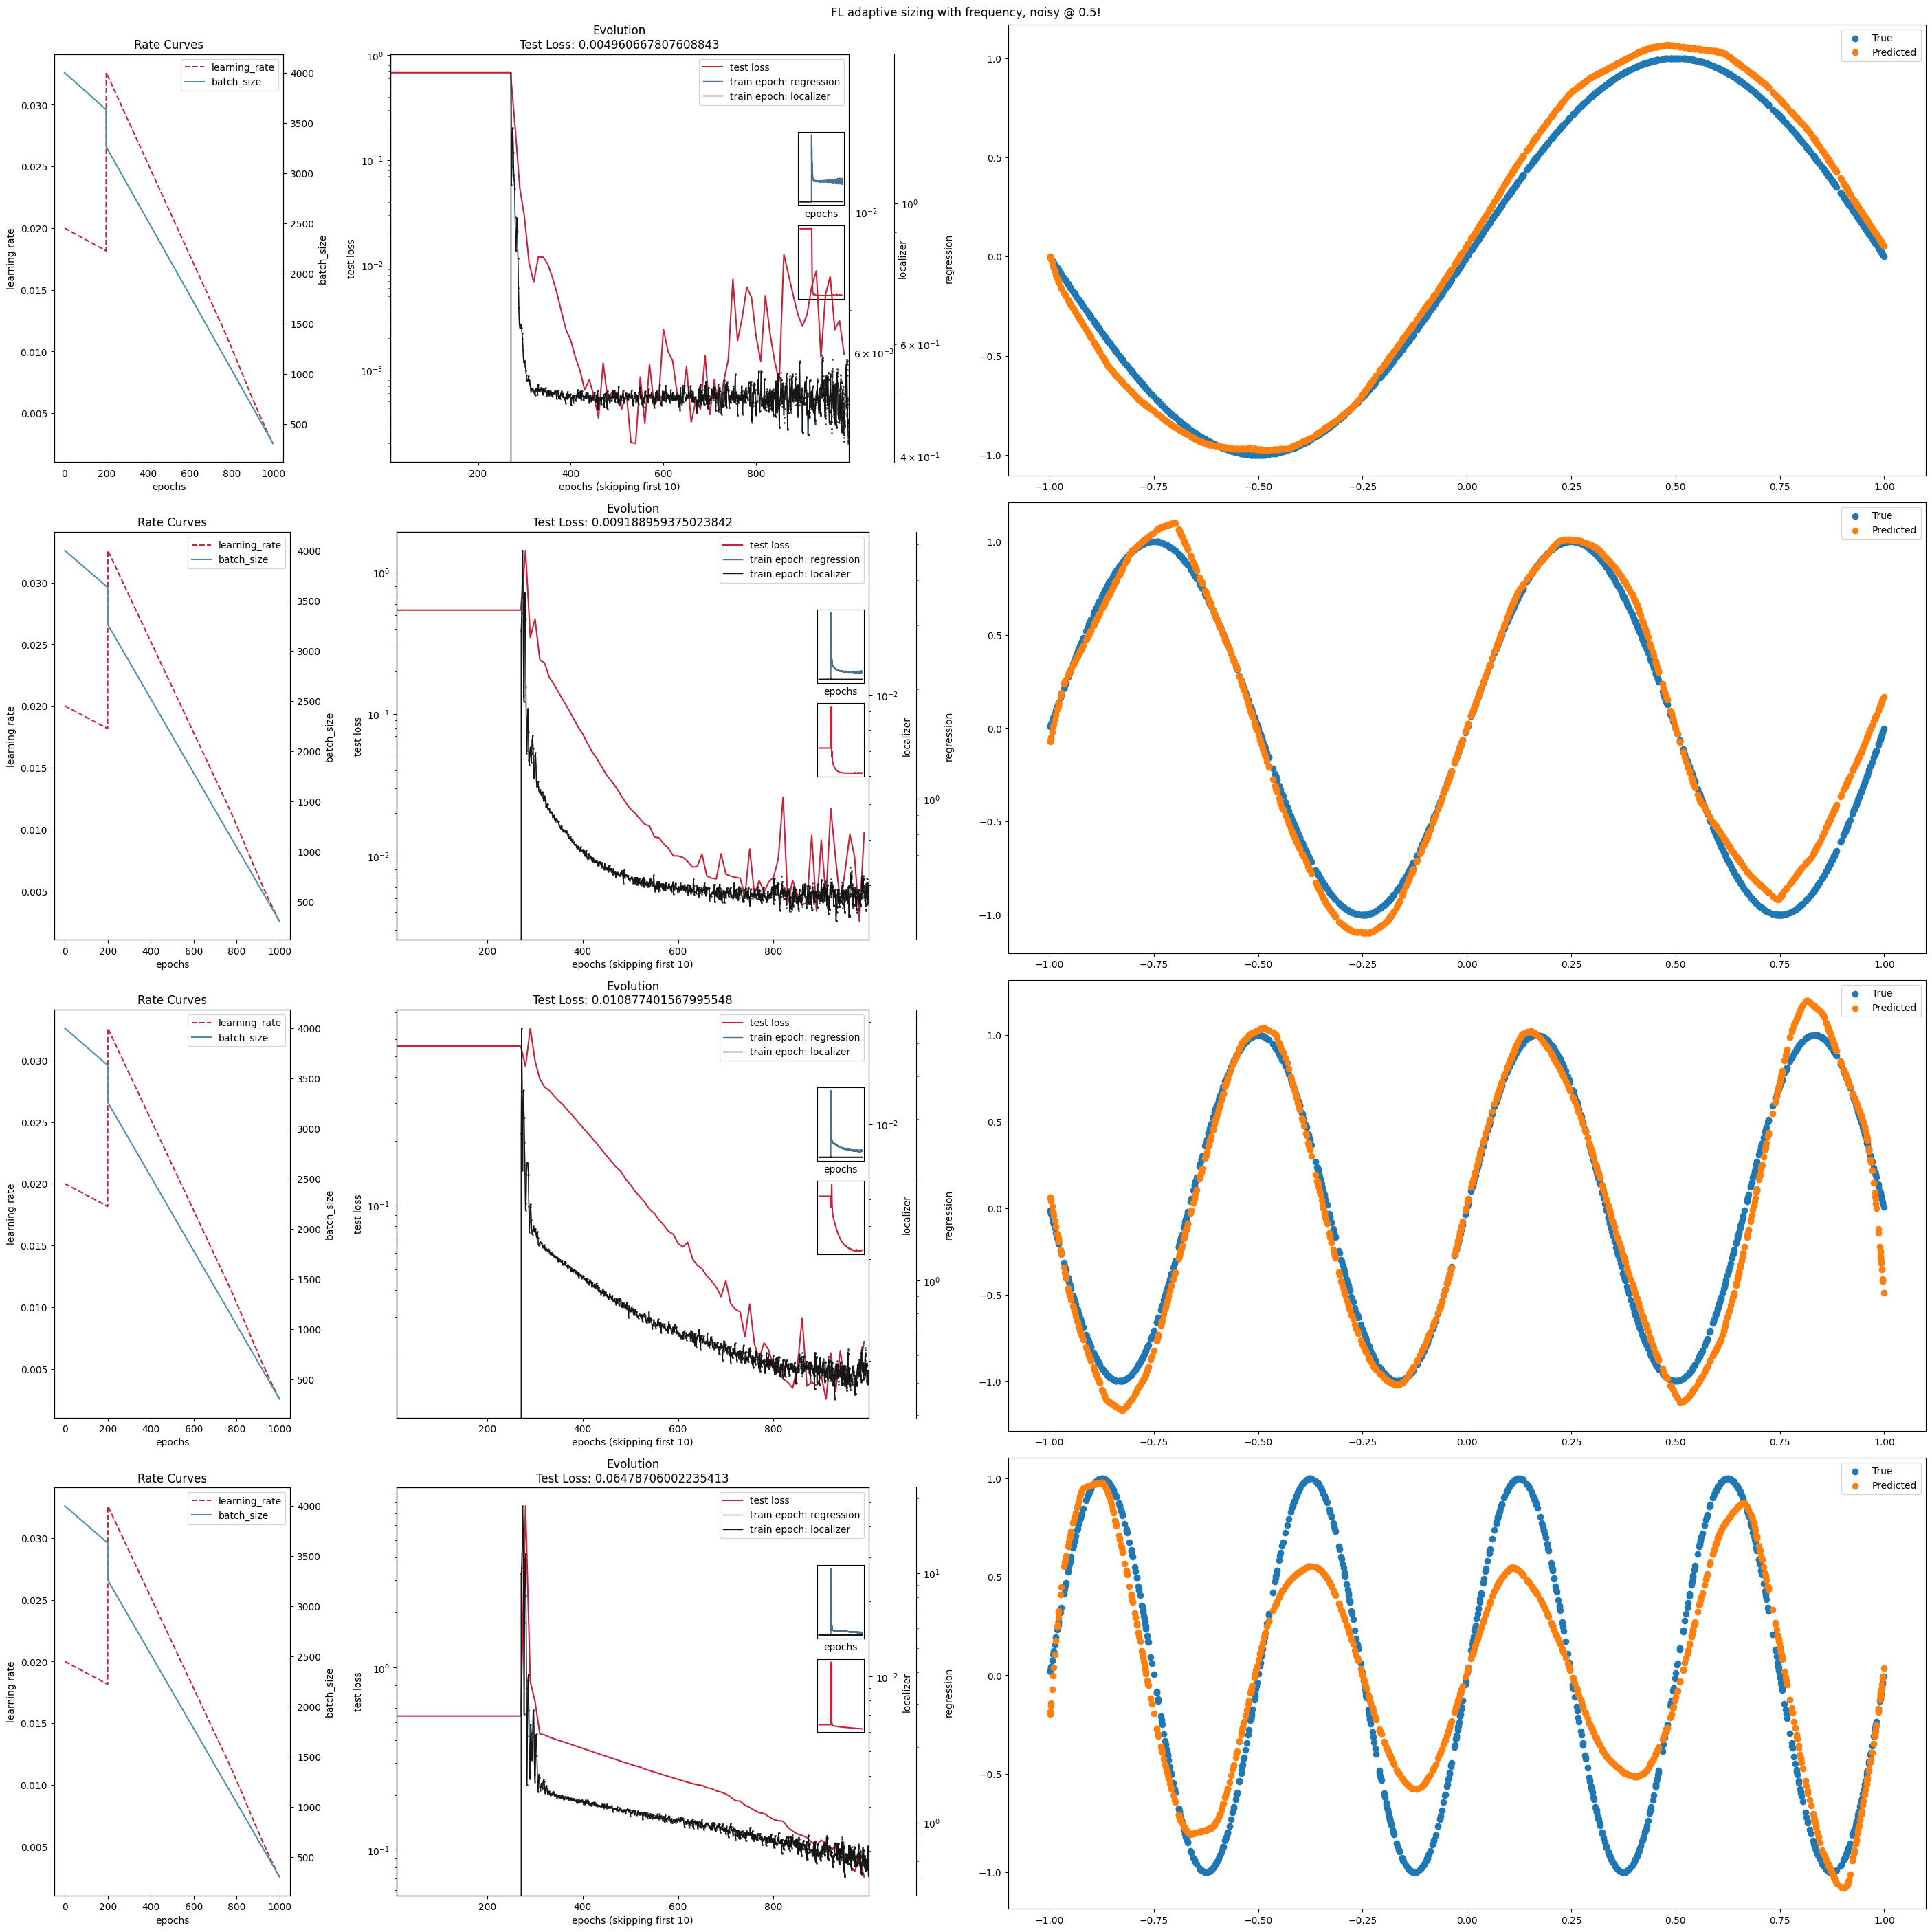

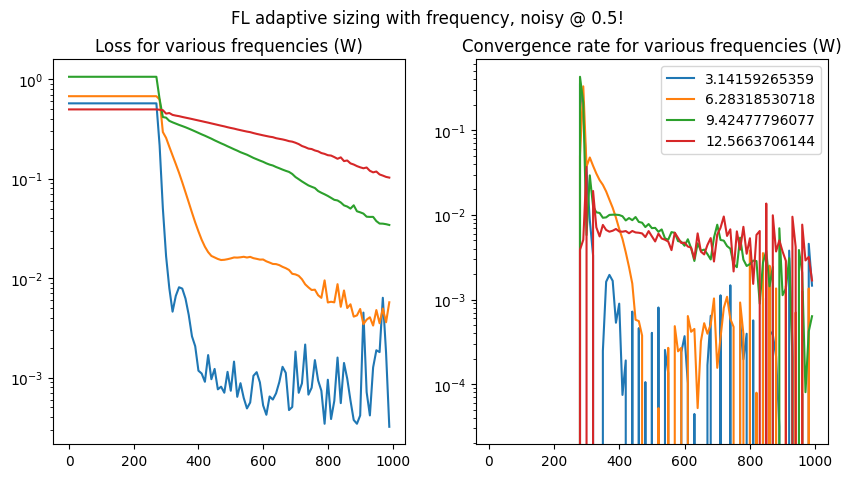

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Xs = np.linspace(-1,1,4000)
p = np.random.permutation(len(Xs))
Xs = Xs[p]
X = torch.from_numpy(Xs).float().unsqueeze(1).to(device)
split = 0.75
train_X = X[:int(split*len(X))]
test_X = X[int(split*len(X)):]
def update_y3(k, noise):
    Ys = np.sin(Xs*k)
    y = torch.from_numpy(Ys).float().unsqueeze(1).to(device)
    train_y = y[:int(split*len(y))] + torch.randn_like(y[:int(split*len(y))])*noise
    test_y = y[int(split*len(y)):]
    return train_y, test_y

reports = []
ks_ = np.array([1,2,3,4])*np.pi
noises = [0.25,0.5]
for j in range(0,2):
    noise = noises[j]
    st = f'FL adaptive sizing with frequency, noisy @ {noise}!'
    fig = plt.figure(layout='constrained', figsize=(28,28))
    subfigs = fig.subfigures(len(ks_),1, hspace=0.01)
    for i,ks in enumerate(ks_):
        train_y,test_y = update_y3(ks, noise)


        k = [ks]*len(fl_sizes)
        if j == 0:
            net = FL(device, fl_sizes, delta, k, opttype=opt, act = act, bias=True)
        else:
            net = FL(device, fl_adapt_sizes(int(ks)), delta, k, opttype=opt, act = act, bias=True)
        report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=4000)
        sfgs = subfigs[i].subfigures(1,2)
        ecran(net, test_X, test_y, report, classification=False,subfig = sfgs[0])
        p1 = sfgs[1].subplots(1,1)
        p1.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
        p1.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
        p1.legend()
        reports.append(report)
    fig.suptitle(st)
    plt.show()
    plt.close(fig)
    fig,axs = plt.subplots(1,2,figsize=(10,5))
    axs[0].set_title('Loss for various frequencies (W)')
    axs[1].set_title('Convergence rate for various frequencies (W)')
    for i in range(len(ks_)):
        axs[0].plot(reports[i][-2],reports[i][-1],label=ks_[i])
        axs[1].plot(reports[i][-2][1:],-np.diff(reports[i][-1]),label=ks_[i])
        axs[0].set_yscale('log')
        axs[1].set_yscale('log')
    fig.suptitle(st)
    plt.legend()
    plt.show()
    plt.close(fig)